(content:references:images_part2)=
# Images Part 2: *Galaxy Morphology Classification*

***Author: Marc Hon***

[](content:references:images_part1) addressed the task of distinguishing between merging and non-merging galaxies. In reality, the morphology of observed galaxies is far more diverse! Consider the following flowchart of decisions deployed to classify the [Galaxy Zoo](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo):


```{figure} images/galaxy_flowchart.png
---
height: 900px
width: 800px
name: galaxy_flowchart
---
The decision tree for manually classifying the DECaLs dataset of galaxy images from Galaxy Zoo.
```

In this notebook, we are going to examine the **Galaxy10** dataset, available on [`AstroNN`](https://astronn.readthedocs.io/en/stable/galaxy10.html).

The original Galaxy10 dataset was derived from Galaxy Zoo (GZ) Data Release 2, in which volunteers classified roughly 270,000 SDSS galaxy images. From these, about 22,000 images were selected into 10 broad morphological classes. GZ subsequently adopted images from the DESI Legacy Imaging Surveys (DECaLS), merging GZ DR2 with DECaLS campaign images to yield 18,000 images that are placed into the same 10 broad classes.

In [1]:
import os, random
import scienceplots
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import h5py

from pathlib import Path
from astropy.io import fits
from matplotlib import cm
from matplotlib.colors import Normalize
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm
from sklearn import metrics
from torchinfo import summary
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision.transforms import functional as TF
plt.style.use('science'); fs=15

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter4' / 'data'

/home/marc/anaconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


```{note}
Because the image dataset occupies a relatively large disk space (158 MB) it is best downloaded separately, rather than being packaged together with this textbook. It is recommended that the dataset is downloaded to the data folder of this Chapter, done by using the `wget` library:

```python
from pathlib import Path
import os
import wget

url = "https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-pristine.fits"

target_folder = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter4' / 'data'

filename = os.path.join(str(target_folder), os.path.basename(url))
wget.download(url, out=filename)
```
## Dataset of Galaxy Morphology

In [2]:
filename = '/Galaxy10_DECals_64.h5'
with h5py.File(str(data_folder_path) + filename, 'r') as F_:
    images = np.array(F_['images'])
    labels = np.array(F_['ans'])

The ten different classes in the dataset are defined as follows:

In [3]:
def plot_montage_per_class(X, y, label_names, k=5, seed=42, figsize=(12, 18)):

    rng = np.random.default_rng(seed)
    classes = sorted(label_names.keys())
    n_classes = len(classes)

    fig, axes = plt.subplots(n_classes, k, figsize=figsize)
    if n_classes == 1:
        axes = axes[np.newaxis, :]
    if k == 1:
        axes = axes[:, np.newaxis]

    for r, c in enumerate(classes):
        idx = np.where(y == c)[0]
        chosen = rng.choice(idx, size=min(k, len(idx)), replace=False)
        for col, img_idx in enumerate(chosen):
            ax = axes[r, col]
            ax.imshow(X[img_idx])
            ax.axis("off")
            if col == 0:
                ax.text(s=f"{c}: {label_names[c]}", fontsize=10, x=-0.5, y=0.45, transform=ax.transAxes,
                       ha='center')

    plt.tight_layout(w_pad=0.05)
    plt.show()

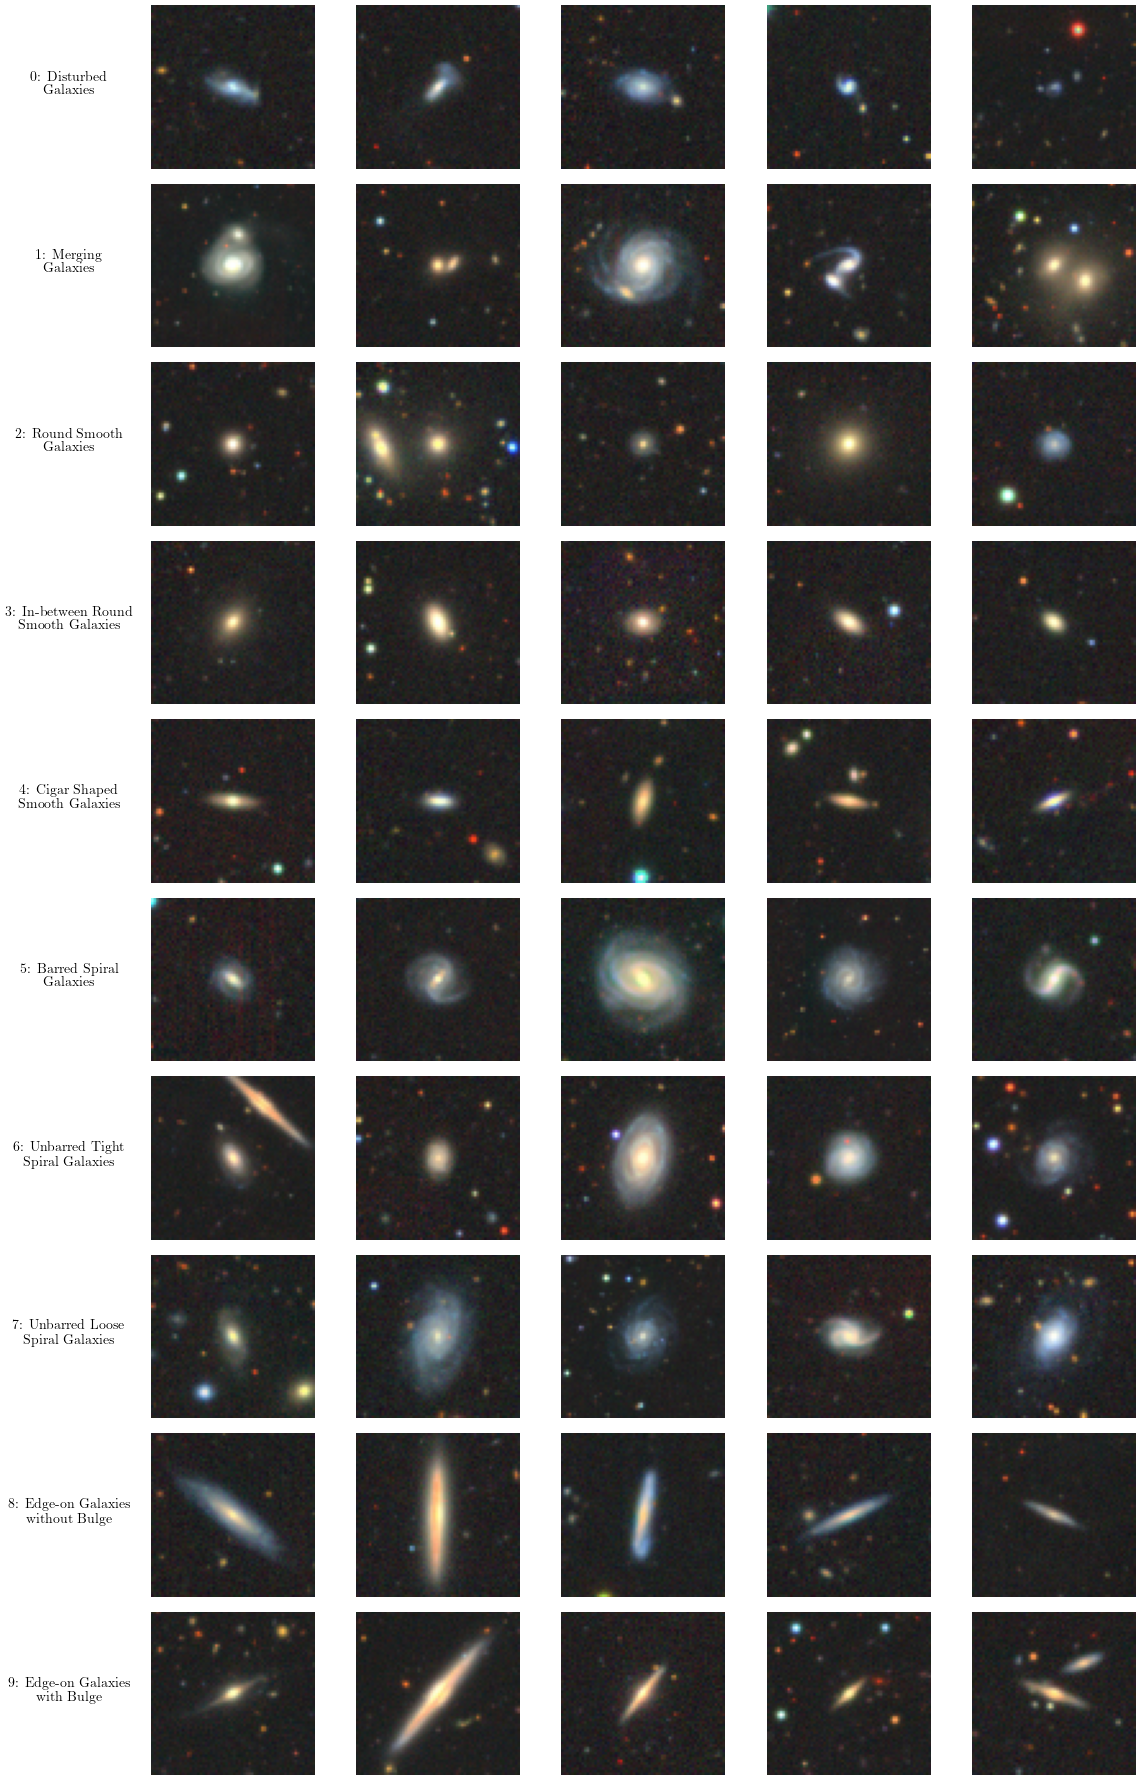

In [4]:
label_names = {
    0: "Disturbed\nGalaxies",
    1: "Merging\nGalaxies",
    2: "Round Smooth\nGalaxies",
    3: "In-between Round\nSmooth Galaxies",
    4: "Cigar Shaped\nSmooth Galaxies",
    5: "Barred Spiral\nGalaxies",
    6: "Unbarred Tight\nSpiral Galaxies",
    7: "Unbarred Loose\nSpiral Galaxies",
    8: "Edge-on Galaxies\nwithout Bulge",
    9: "Edge-on Galaxies\nwith Bulge"
}

plot_montage_per_class(images, labels, label_names, k=5)

Now, we will process the dataset into training and test sets for a **multiclass classification** task. The output vector `y` contains integer values $\in [0,9]$ representing the classes defined above.

Similar to the binary classification task, we ensure that the input has the required dimensions of $N \times C \times W \times H$, where $C$ is the number of channels (three). Subsequently, the dataset is split into *training*, *validation*, and *test* sets.

In [5]:
#### Train-Validation-Test Split ####

random_state = 42

X = np.transpose(np.asarray(images).astype('float32'), (0,3,1,2))
y = np.asarray(labels).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)


#### Convert to Tensor Datasets ####

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
valid_ds = TensorDataset(X_valid_tensor, y_valid_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

#### Create DataLoader ####

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

## Multiclass Convolutional Neural Network (CNN)

The CNN presented here is identical to that in [](content:references:images_part1), except that the output layer contains **10** nodes (for 10 classes), instead of 2 nodes for a binary classification.

```{figure} images/Galaxy10Net.png
---
height: 250px
width: 400px
name: Galaxy10Net
---
Schematic of the 2D CNN used in the Galaxy Morphology Multiclass classification.
```

In [12]:
class CNNModel(nn.Module):
    def __init__(self, imsize):
        super(CNNModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.bn1   = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm2d(32)
        
        # Pooling & dropout
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop  = nn.Dropout(0.5)
        
        # Compute flattened size dynamically
        dummy_input = torch.zeros(1, 3, imsize, imsize)
        dummy_output = self._forward_features(dummy_input)
        flatten_dim = dummy_output.view(1, -1).size(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(flatten_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
        self._init_weights()

    def _forward_features(self, x):
        x = self.drop(self.pool(F.relu(self.bn1(self.conv1(x)))))
        x = self.drop(self.pool(F.relu(self.bn2(self.conv2(x)))))
        x = self.drop(self.pool(F.relu(self.bn3(self.conv3(x)))))
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # binary classification output
        return x
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)   # gamma
                nn.init.zeros_(m.bias)    # beta
                
imsize = X_train.shape[2]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(imsize).to(device)
summary(model, input_size=(1, 3, imsize, imsize))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 10]                   --
├─Conv2d: 1-1                            [1, 8, 64, 64]            608
├─BatchNorm2d: 1-2                       [1, 8, 64, 64]            16
├─MaxPool2d: 1-3                         [1, 8, 32, 32]            --
├─Dropout: 1-4                           [1, 8, 32, 32]            --
├─Conv2d: 1-5                            [1, 16, 32, 32]           1,168
├─BatchNorm2d: 1-6                       [1, 16, 32, 32]           32
├─MaxPool2d: 1-7                         [1, 16, 16, 16]           --
├─Dropout: 1-8                           [1, 16, 16, 16]           --
├─Conv2d: 1-9                            [1, 32, 16, 16]           4,640
├─BatchNorm2d: 1-10                      [1, 32, 16, 16]           64
├─MaxPool2d: 1-11                        [1, 32, 8, 8]             --
├─Dropout: 1-12                          [1, 32, 8, 8]             --
├─Linear

Finally, we define the optimizer and the loss function. Because we are dealing with multiclass classification, the **categorical cross-entropy** loss is applied (`CrossEntropyLoss`).

In [13]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) 
criterion = nn.CrossEntropyLoss()

The following is the training loop, where we track the `CrossEntropyLoss` and accuracy of the model over 100 iterations.

In [14]:
def train_model(model, train_loader):
    nb_epoch = 100
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(nb_epoch):
        # --- Training ---
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.squeeze().long())
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)

            preds = torch.argmax(y_pred, dim=1)
            train_correct += (preds == y_batch.squeeze()).sum().item()
            train_total += y_batch.size(0)

        train_loss /= train_total
        train_acc = train_correct / train_total

        # --- Validation ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)

                loss = criterion(y_pred, y_batch.squeeze().long())

                val_loss += loss.item() * X_batch.size(0)
                preds = torch.argmax(y_pred, dim=1)
                val_correct += (preds == y_batch.squeeze()).sum().item()
                val_total += y_batch.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        # Save epoch results
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{nb_epoch} - "
                  f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, "
                  f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")
            
    return history

history = train_model(model, train_loader)

Epoch 1/100 - train_loss: 2.2596, train_acc: 0.1800, val_loss: 2.2064, val_acc: 0.1660
Epoch 11/100 - train_loss: 1.5830, train_acc: 0.4113, val_loss: 1.8160, val_acc: 0.3236
Epoch 21/100 - train_loss: 1.4380, train_acc: 0.4685, val_loss: 1.6767, val_acc: 0.3844
Epoch 31/100 - train_loss: 1.3579, train_acc: 0.4985, val_loss: 1.6964, val_acc: 0.3737
Epoch 41/100 - train_loss: 1.2991, train_acc: 0.5286, val_loss: 1.5848, val_acc: 0.4164
Epoch 51/100 - train_loss: 1.2419, train_acc: 0.5531, val_loss: 1.5129, val_acc: 0.4519
Epoch 61/100 - train_loss: 1.1964, train_acc: 0.5720, val_loss: 1.6055, val_acc: 0.4232
Epoch 71/100 - train_loss: 1.1478, train_acc: 0.5886, val_loss: 1.4689, val_acc: 0.4716
Epoch 81/100 - train_loss: 1.1117, train_acc: 0.6060, val_loss: 1.5092, val_acc: 0.4615
Epoch 91/100 - train_loss: 1.0794, train_acc: 0.6121, val_loss: 1.4178, val_acc: 0.4755


## Performance Metrics

The network now is noticeably overfitting significantly based on the divergence of the training loss and accuracy from the validation counterparts.

In [17]:
def plot_training_curves(history):
    loss = history["train_loss"]
    val_loss = history["val_loss"]
    acc = history["train_acc"]
    val_acc = history["val_acc"]

    epochs = list(range(1, len(loss) + 1))

    figsize = (8, 4)
    fig, axis1 = plt.subplots(figsize=figsize)

    plot1_acc = axis1.plot(epochs, acc, 'navy', label='accuracy')
    plot1_val_acc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")
    plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
    plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")

    plots = plot1_acc + plot1_val_acc + plot1_loss + plot1_val_loss
    labs = [plot.get_label() for plot in plots]
    axis1.set_xlabel('Epoch', fontsize=fs-3)
    axis1.set_ylabel('Loss/Accuracy', fontsize=fs-3)
    plt.title("Loss/Accuracy History", fontsize=fs-3)
    plt.tight_layout()
    axis1.tick_params(axis='both', labelsize=fs-3); 
    axis1.legend(loc='center right', frameon=True, framealpha=0.85, prop={'size':fs-3})
    plt.show()
    
def plot_confusion_matrix(model, data_loader, device, class_names):
    model.eval()

    # --- normalize class names to an ordered list ---
    if isinstance(class_names, dict):
        # assume labels 0..K-1
        classes = list(range(len(class_names)))
        names   = [class_names[i] for i in classes]
    else:
        names   = list(class_names)
        classes = list(range(len(names)))
    K = len(names)

    y_true, y_pred = [], []
    correct, total = 0, 0

    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds  = torch.argmax(logits, dim=1)

            y_true.append(yb.cpu().numpy())
            y_pred.append(preds.cpu().numpy())
            correct += (preds == yb.squeeze()).sum().item()
            total   += yb.size(0)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    acc = correct / total

    # --- Confusion matrix (rows=true, cols=pred) ---
    cm = metrics.confusion_matrix(y_true, y_pred, labels=classes)
    cm = cm.astype(float)
    cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)  # row-normalized

    # --- Classification report (weighted) ---
    report = metrics.classification_report(
        y_true, y_pred, target_names=names, digits=2, output_dict=True
    )
    precision = report['weighted avg']['precision']
    recall    = report['weighted avg']['recall']
    f1        = report['weighted avg']['f1-score']

    # --- Plot ---
    fs = 10  # base font size; tweak as needed
    fig, ax = plt.subplots(figsize=(1.0 + 0.6*K, 1.0 + 0.55*K))
    im = ax.imshow(cm_norm, cmap='binary_r')

    ax.set_title('Confusion Matrix (row-normalized)', fontsize=fs+2, pad=12)
    ax.set_xticks(classes); ax.set_yticks(classes)
    ax.set_xticklabels(names, fontsize=fs-1, rotation=90, ha='center')
    ax.set_yticklabels(names, fontsize=fs-1)
    ax.set_xlabel('Predicted', fontsize=fs)
    ax.set_ylabel('True', fontsize=fs)

    # Annotate cells
    thresh = cm_norm.max() / 2.0
    for i in range(K):
        for j in range(K):
            val = cm_norm[i, j]
            ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                    color="white" if val < thresh else "black", fontsize=fs)

    # Add a colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Fraction Within True Class', rotation=90, va='center')

    # Metrics text box
    fig.text(1.195, 0.6,
             f"Acc: {acc:.3f}\nPrec(w): {precision:.2f}\nRecall(w): {recall:.2f}\nF1(w): {f1:.2f}",
             va='center', ha='right', fontsize=fs,
             bbox=dict(facecolor='white', alpha=0.85, boxstyle='round,pad=0.4'))

    plt.tight_layout()
    plt.show()

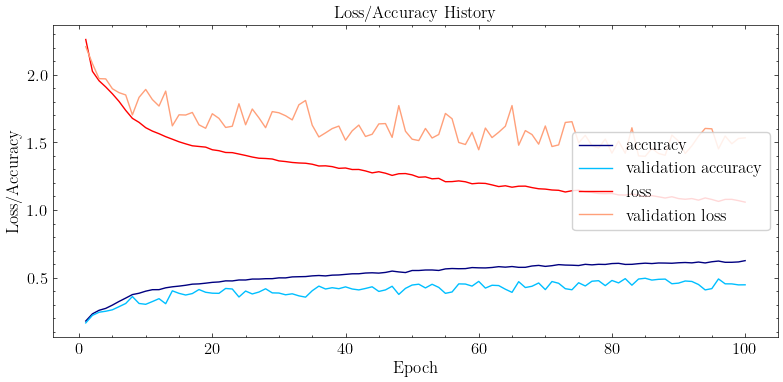

In [18]:
plot_training_curves(history)

The performance of the classifier on the test set is not very remarkable, with strong predictions along the **off-diagonal** elements.

```{tip}
Why does the CNN in this application overfit much more significantly compared to the CNN in [](content:references:images_part1), despite having the same network architecture?
```

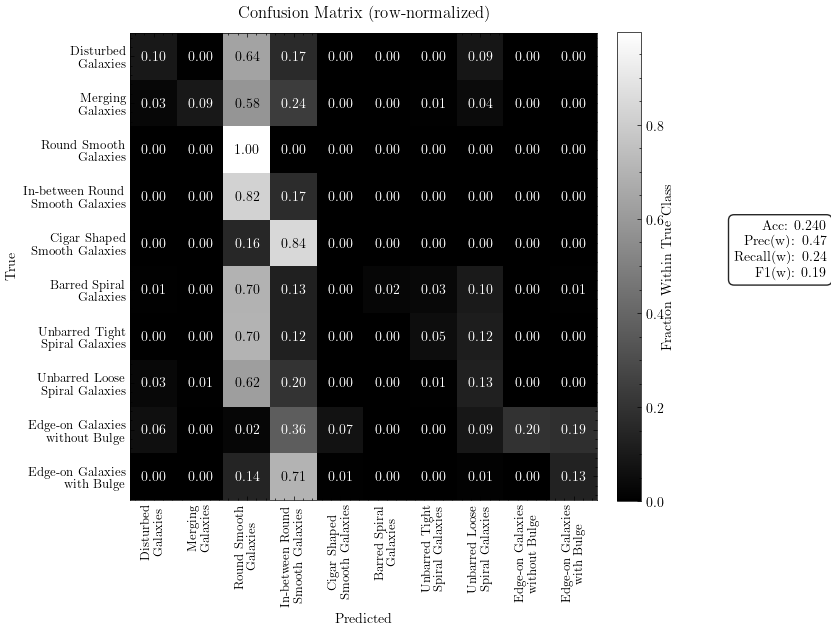

In [11]:
plot_confusion_matrix(model, test_loader, device, class_names=label_names)

## Confidence of Neural Networks

Neural networks in classification tasks produce not only a predicted label but also an **associated probability**, often interpreted as the model’s **confidence** in that prediction. A **well-calibrated** model is one where these confidence values correspond directly to the actual likelihood of correctness. 

For instance, if the model assigns a confidence of 0.8 to a set of predictions, then approximately 80% of those predictions should be correct in reality. Otherwise, common calibration pathologies are the following:

- **Overconfidence:** The model’s predicted probabilities are systematically higher than the true accuracy. For instance, the model might assign 90% confidence to predictions that are only correct 70% of the time. Machine learning methods prone to overfitting (like neural networks) are commonly overconfident.

- **Underconfidence:** The model’s predicted probabilities are systematically lower than the true accuracy. For example, predictions with 60% confidence may actually be correct 80% of the time. While safer than overconfidence, underconfidence reduces the model’s usefulness, as predictions may be undervalued and ignored even when they are reliable.

```{note}
Is it better for a machine learning algorithm (or any measuring device) to be **underconfident** or **overconfident**?
```

To visualize how well a machine learning model's confidence corresponds to the occurrence rate of the true class, a **reliability curve** can be plotted, as shown below.

In [26]:
@torch.no_grad()
def collect_probs_labels(model, loader, device):
    model.eval()
    probs_list, logits_list, labels_list = [], [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)                 # (B, K)
        probs = torch.softmax(logits, dim=1)
        probs_list.append(probs.cpu().numpy())
        logits_list.append(logits.cpu().numpy())
        labels_list.append(yb.squeeze().long().cpu().numpy())
    P = np.concatenate(probs_list, axis=0) # (N, K)
    y = np.concatenate(labels_list, axis=0) # (N,)
    L = np.concatenate(logits_list, axis=0)
    return P, y, L

def reliability_global(P, y, n_bins=10, figsize=(6, 5), title="Reliability Curve"):
    """
    P : (N, K) softmax probabilities
    y : (N,)   integer labels in [0..K-1]
    """
    # Top-1 confidence and correctness
    conf = P.max(axis=1)                 # predicted confidence
    pred = P.argmax(axis=1)              # predicted class
    corr = (pred == y).astype(np.float32)# 1 if correct else 0

    # Bin edges and indices
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_idx = np.digitize(conf, bins) - 1
    bin_idx = np.clip(bin_idx, 0, n_bins - 1)

    # Per-bin stats
    bin_conf, bin_acc, bin_count = np.zeros(n_bins), np.zeros(n_bins), np.zeros(n_bins, dtype=int)
    for b in range(n_bins):
        m = (bin_idx == b)
        if m.any():
            bin_conf[b]  = conf[m].mean()
            bin_acc[b]   = corr[m].mean()
            bin_count[b] = m.sum()
        else:
            bin_conf[b] = np.nan
            bin_acc[b]  = np.nan

    # ECE (ignore empty bins)
    mask = ~np.isnan(bin_conf)
    N = len(conf)
    ece = np.sum((bin_count[mask] / N) * np.abs(bin_acc[mask] - bin_conf[mask]))

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0,1],[0,1],'k--',lw=1,alpha=0.6,label='Perfect Calibration')
    ax.plot(bin_conf[mask], bin_acc[mask], marker='o', lw=2, label='Model Reliability')
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.set_xlabel("Predicted Probability", fontsize=fs-3)
    ax.set_ylabel("Empirical Accuracy", fontsize=fs-3)
    ax.set_title(f"{title}  |  ECE={ece:.3f}", fontsize=fs-3)
    ax.grid(alpha=0.2)
    ax.tick_params(axis='both', labelsize=fs-3); 
    ax.legend(loc='lower right', prop={'size': fs-3})

    # Frequency bars on secondary axis
    ax2 = ax.twinx()
    centers = (bins[:-1] + bins[1:]) / 2
    ax2.bar(centers, bin_count, width=1.0/n_bins*0.9, alpha=0.25, color='C0')
    ax2.set_ylim(0, max(bin_count.max(), 1))
    ax2.set_yticks([])
    ax2.tick_params(axis='both', labelsize=fs-3); 

    plt.tight_layout()
    return fig, ece

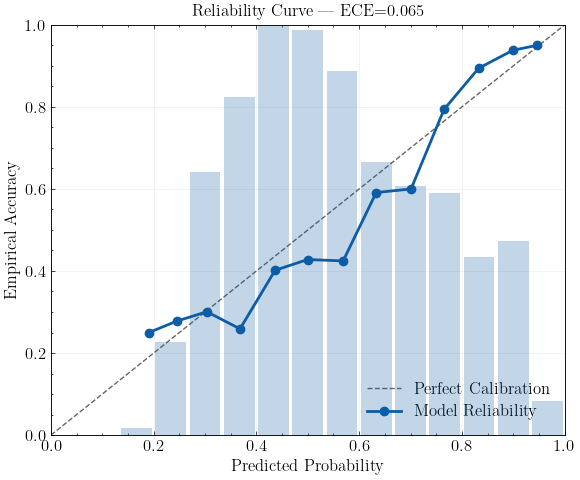

In [27]:
P, y, L = collect_probs_labels(model, valid_loader, device)

fig, ece = reliability_global(P, y, n_bins=15); plt.show()

On a reliability curve, the horizontal axis shows the predicted probability in user-defined bins. For predictions in each of those bins, the accuracy of those predictions are calculated.

> **If the model is perfectly calibrated, all points should fall on the diagonal line ($y$ = $x$).**


The **Expected Calibration Error (ECE)**, as introduced by [Guo et al. (2017)](https://arxiv.org/abs/1706.04599), is a convenient scalar summary statistic describing how well a model is calibrated. It is defined as 

$$
\text{ECE}=\sum_{b=1}^{B}\frac{|\mathcal{B}_b|}{N}\,\left|\text{acc}(\mathcal{B}_b)-\text{conf}(\mathcal{B}_b)\right|,
$$

where $N$ is the number of samples and $B$ is the number of confidence bins, such that $\mathcal{B}_b$ are the samples that fall within $b \in B$. The larger the ECE, the greater the discrepancy between the model's confidence and the true occurrence rate of a class prediction. 

Note that in the reliability graph predicted above, the **bar graph** in the background indicates how frequently the model predicts a particularly probability among predictions across the dataset.

```{tip}
Does the reliability of the CNN model agree with your diagnostics of the training (i.e., overfitting) from the training curves?
```

## Augmenting the Image Dataset

To prevent the model from overfitting the dataset, it needs to be prevented from using highly specific image features (e.g., noise in certain localized pixels in the image) that does not generalize well across other examples. One way to achieve this is to use **data augmentation**, in which spatial transformations are applied to the training data to make new copies of the existing training images. This prevents the model from 'memorizing' details from the image, and to encourage it to learn proper, class-specific features.

In Pytorch, these image transforms can be done using `torchvision` implemented into a a `Dataset`:

In [34]:
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset, TensorDataset, DataLoader

class TensorWithTransform(Dataset):
    def __init__(self, tensors, transform=None):
        self.tensors = tensors 
        self.transform = transform
    def __len__(self):
        return self.tensors[0].size(0)
    
    def __getitem__(self, idx):
        x = self.tensors[0][idx]
        y = self.tensors[1][idx]
        
        if self.transform:                         
            # Random rotation (-90 to 90 degrees)
            angle = random.uniform(-90, 90)
            x = TF.rotate(x, angle)
            
        return x, y
    
# Dataset without transforms for original view
orig_dataset = TensorWithTransform((X_train_tensor, y_train_tensor), transform=False)
# Dataset with transforms for augmented view
aug_dataset = TensorWithTransform((X_train_tensor, y_train_tensor), transform=True)

If we suspect that the CNN is memorizing features at very specific regions in the images (like background stars or galaxies), we may prefer to continuously rotate the image orientation as new examples are generated during training.

The outcome of such a transformation can be visualized by the following on random examples:

In [29]:
def visualize_transformation():
    # Visualize first 5 samples: original (left) vs augmented (right)
    fig, axes = plt.subplots(5, 2, figsize=(6, 12))
    for k, i in enumerate(np.random.randint(len(orig_dataset), size=5)):
        # Original
        img_orig, label = orig_dataset[i]
        axes[k, 0].imshow(img_orig.permute(1, 2, 0).cpu().numpy().astype('uint8'))
        axes[k, 0].set_title(f"Original", fontsize=fs-3)
        axes[k, 0].axis("off")

        # Augmented
        img_aug, _ = aug_dataset[i]
        axes[k, 1].imshow(img_aug.permute(1, 2, 0).cpu().numpy().astype('uint8'))
        axes[k, 1].set_title("Augmented", fontsize=fs-3)
        axes[k, 1].axis("off")
        axes[k, 1].text(x=1.2, y=0.5, transform = axes[k, 1].transAxes,
                       s=f'{label_names[label.item()]}', fontsize=fs-3)
    plt.tight_layout(w_pad=2)
    plt.show()

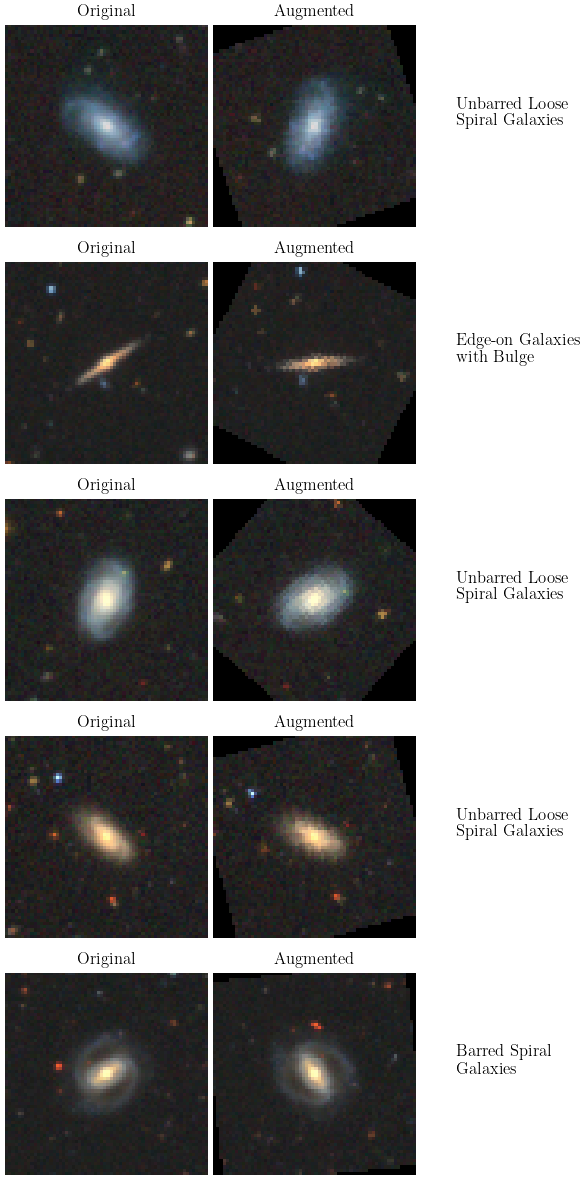

In [30]:
visualize_transformation()

This `Dataset` applying transforms into the training loop can be wrapped into a standard Pytorch `DataLoader` and trained as usual. Here, we will augment the training set only, while we leave the validation and testing set un-augmented.

In [38]:
train_ds_augmented = TensorWithTransform((X_train_tensor, y_train_tensor),
                                  transform=True)

train_loader_aug = DataLoader(train_ds_augmented, batch_size=batch_size, shuffle=True)

Next, a new model is instantiated and trained, specifically for this instance for which the augmented dataset is used.

In [39]:
model_aug = CNNModel(imsize).to(device)
optimizer = optim.Adam(model_aug.parameters(), lr=1e-3, weight_decay=1e-4) 

history_aug = train_model(model_aug, train_loader_aug)

Epoch 1/100 - train_loss: 2.2616, train_acc: 0.1692, val_loss: 2.3035, val_acc: 0.1474
Epoch 11/100 - train_loss: 1.7415, train_acc: 0.3522, val_loss: 1.7420, val_acc: 0.3528
Epoch 21/100 - train_loss: 1.5403, train_acc: 0.4342, val_loss: 1.4902, val_acc: 0.4693
Epoch 31/100 - train_loss: 1.4739, train_acc: 0.4656, val_loss: 1.4025, val_acc: 0.5014
Epoch 41/100 - train_loss: 1.4129, train_acc: 0.4830, val_loss: 1.3620, val_acc: 0.5037
Epoch 51/100 - train_loss: 1.3647, train_acc: 0.5038, val_loss: 1.4259, val_acc: 0.4575
Epoch 61/100 - train_loss: 1.3357, train_acc: 0.5224, val_loss: 1.3596, val_acc: 0.4902
Epoch 71/100 - train_loss: 1.3107, train_acc: 0.5253, val_loss: 1.2975, val_acc: 0.5217
Epoch 81/100 - train_loss: 1.2806, train_acc: 0.5419, val_loss: 1.2820, val_acc: 0.5284
Epoch 91/100 - train_loss: 1.2606, train_acc: 0.5469, val_loss: 1.3099, val_acc: 0.5256


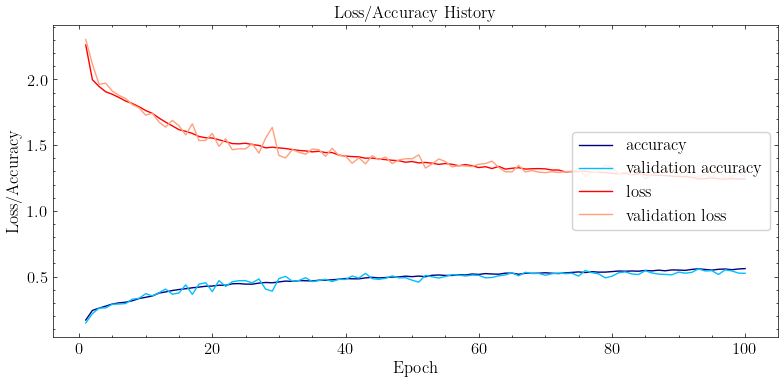

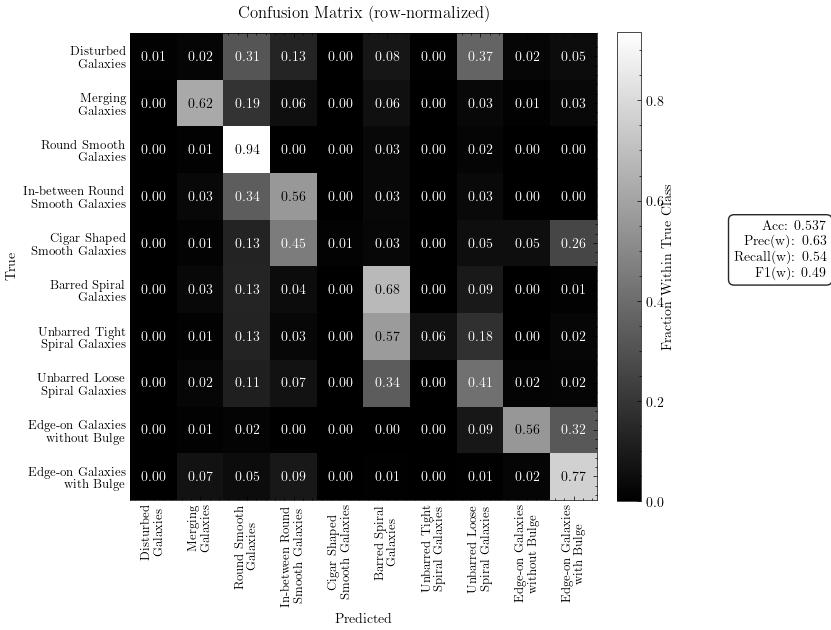

In [40]:
plot_training_curves(history_aug)
plot_confusion_matrix(model_aug, test_loader, device, class_names=label_names)

The model trained on the augmented shows a much better generalization performance:
- The training and validation loss curves do not diverge as much as before
- More predictions fall along the diagonal in the confusion matrix

This improvement can also be seen in the confidence of the model, which is overall better calibrated.

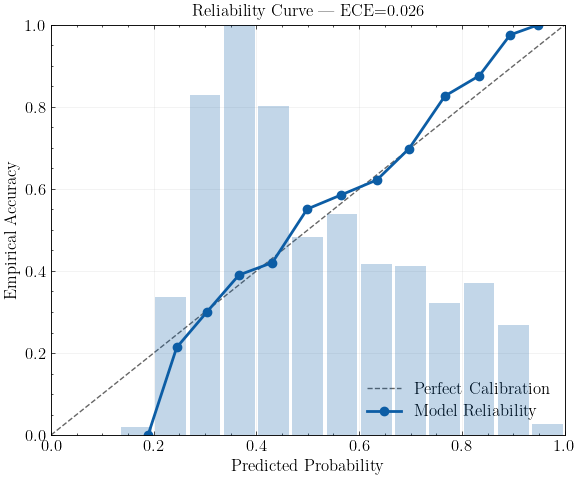

In [42]:
P, y, L = collect_probs_labels(model_aug, valid_loader, device)
fig, ece = reliability_global(P, y, n_bins=15); plt.show()

```{admonition} Exercise 1: Understanding Multiclass Visual Features
:class: note

A critical question in scientific applications is: *what features is the network actually using, and are these the ones we care about?*  

One useful tool to probe this is **Grad-CAM**, which visualizes the image regions most influential for the network’s decision.

---

**Tasks:**

1. Starting from the provided `GradCAM` implementation (see [](content:references:images_part1)), adapt the code to visualize which regions of the input image are most salient for a chosen class prediction.  
   - *Hint:* Modify the `score` variable appropriately so that the heatmap corresponds to the class logit of interest, as discussed in the Section’s exercise.
 
2. Focus on a specific class of galaxies (e.g., *class 5: Barred Spiral Galaxies*).  
   For this class, identify:  
   - **Correct predictions**: examples where the CNN assigns the right label with high confidence.  
   - **Incorrect predictions**: examples where the CNN mistakenly labels the image as this class.  

   Generate Grad-CAM visualizations for both sets.

---

**Questions:**

- Compare the Grad-CAM maps for correct vs. incorrect predictions. Are different image regions highlighted? Do the “mistaken” heatmaps suggest the CNN is latching onto irrelevant or spurious features?  
- For correct predictions, do the highlighted regions correspond to astrophysically meaningful structures (e.g., bars, spiral arms, edge-on features)?  
- For incorrect predictions, does the CNN appear to “overfit” to small-scale structures, noise, or artifacts rather than true morphological indicators? 
```


```{admonition} Exercise 2: Further Image Transformations
:class: note

`TensorWithTransform` currently applies only rotation. `torchvision` provides many additional, label-preserving transforms that can improve generalization by discouraging the CNN from memorizing specific pixels and encouraging invariances that are astrophysically reasonable.

---

**Tasks:**

1. Replace `TF.rotate` in `TensorWithTransform` with one or more transformations from the functional API  
   (see: https://docs.pytorch.org/vision/0.9/transforms.html#functional-transforms).  
   
   Focus on transforms that reduce reliance on exact location/pose:
   - `TF.hflip(x)` and `TF.vflip(x)` (orientation invariance)  
   - `TF.affine(x, angle=…, translate=(tx,ty), scale=s, shear=…)` (small shifts/zoom/shear)  
   - `TF.center_crop(x, output_size)` (forces robustness to slight recentering)
   
 
2. Instantiate a new model and train with your chosen transforms applied in the `DataLoader`.  
   

3. Report performance on a held-out validation/test set using:
   - Top-1 accuracy and **macro-F1** (to account for class imbalance)  
   - Calibration: **ECE** and a **global reliability curve**  
   - A confusion matrix highlighting the most confused class pairs
   
   
4. Consider combining transformations as shown in `TensorWithCompositeTransforms` below and repeat steps 1-3.

---

**Questions:**

- Which transformations most improved robustness (accuracy, macro-F1) and calibration (ECE)? 
- What does the combination of transformations in `TensorWithCompositeTransforms` do? Which transforms would you expect to help when data are **noisy** or **off-center**? Which of these might harm the galaxy morphology (and should be avoided or limited)?

---

**Code Snippet:**


```python
import random, torchvision.transforms.functional as TF

class TensorWithCompositeTransforms(Dataset):
    def __init__(self, tensors, do_aug=True):
        self.X, self.y = tensors
        self.do_aug = do_aug

    def __getitem__(self, i):
        x, y = self.X[i], self.y[i].long()   # x: (C,H,W) tensor
        if self.do_aug:
            if random.random() < 0.5: x = TF.hflip(x)
            if random.random() < 0.5: x = TF.vflip(x)
            ang = random.uniform(-30, 30)
            tx  = random.randint(-6, 6)
            ty  = random.randint(-6, 6)
            sc  = random.uniform(0.9, 1.1)
            x = TF.affine(x, angle=ang, translate=(tx,ty), scale=sc, shear=0.0)
        return x, y

```

## Further Reading: Other Methods of Calibrating Probabilities

Besides preventing overfitting to reduce overconfident predictions, there exist **ad-hoc** methods to calibrate the probabilities of machine learning models by modifying their prediction scores **after** training.

For `scikit-learn` models, the library has dedicated [Probability Calibration](https://scikit-learn.org/stable/modules/calibration.html) methods, such as the Platt method and isotonic regression.

For neural network classifiers, there exists [Temperature Scaling](https://arxiv.org/abs/1706.04599) approaches that "softens" the input logits with a learnable parameter, such that the predicted softmax probability is less overconfident. An example repository that implements this in Pytorch is provided [here](https://github.com/gpleiss/temperature_scaling/).